## '''Trains a denoising autoencoder on MNIST dataset.

Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true data.

Noise + Data ---> Denoising Autoencoder ---> Data

Given a training dataset of corrupted data as input and
true data as output, a denoising autoencoder can recover the
hidden structure to generate clean data.

This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

In [1]:

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(43)

In [2]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 1024
kernel_size = 3
latent_dim = 16

In [4]:
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                100368    
Total params: 100,688
Trainable params: 100,688
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
____________________________________

In [5]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_noisy,
            x_train,
            validation_data=(x_test_noisy, x_test),
            epochs=5,
            batch_size=batch_size)

Epoch 1/5
59/59 [==============================] - 25s 414ms/step - loss: 0.1288 - val_loss: 0.0694
Epoch 2/5
59/59 [==============================] - 24s 415ms/step - loss: 0.0689 - val_loss: 0.0682
Epoch 3/5
59/59 [==============================] - 21s 354ms/step - loss: 0.0678 - val_loss: 0.0678
Epoch 4/5
59/59 [==============================] - 21s 350ms/step - loss: 0.0674 - val_loss: 0.0662
Epoch 5/5
59/59 [==============================] - 21s 361ms/step - loss: 0.0637 - val_loss: 0.0530


In [6]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

In [7]:
# # Mean Square Error (MSE) loss function, Adam optimizer
# autoencoder.compile(loss='mse', optimizer='adam')

# # train the autoencoder
# autoencoder.fit(x_train_noisy,
#                 x_train,
#                 validation_data=(x_test_noisy, x_test),
#                 epochs=5,
#                 batch_size=batch_size)

# # predict the autoencoder output from corrupted test images
# x_decoded = autoencoder.predict(x_test_noisy)

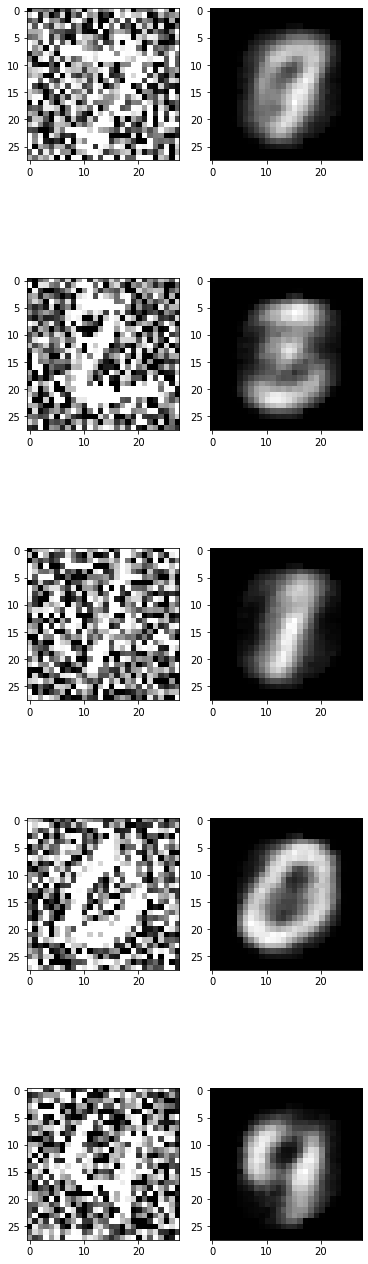

In [8]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
denoised_samples_number = 5
noisy_samples = x_test_noisy[0:denoised_samples_number]
denoised_samples = autoencoder.predict(noisy_samples)

fig, axs = plt.subplots(denoised_samples_number, 2, figsize=(6, 24))
axs_ = axs.ravel()

for i, (ns, ds) in enumerate(zip(noisy_samples, denoised_samples)):
  axs_[2*i].imshow(ns, cmap="gray")
  axs_[2*i + 1].imshow(ds, cmap="gray")

In [9]:
# # 3 sets of images with 9 MNIST digits
# # 1st rows - original images
# # 2nd rows - images corrupted by noise
# # 3rd rows - denoised images
# rows, cols = 3, 9
# num = rows * cols
# imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
# imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
# imgs = np.vstack(np.split(imgs, rows, axis=1))
# imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
# imgs = np.vstack([np.hstack(i) for i in imgs])
# imgs = (imgs * 255).astype(np.uint8)
# plt.figure()
# plt.axis('off')
# plt.title('Original images: top rows, '
#           'Corrupted Input: middle rows, '
#           'Denoised Input:  third rows')
# plt.imshow(imgs, interpolation='none', cmap='gray')
# Image.fromarray(imgs).save('corrupted_and_denoised.png')
# plt.show()
